In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm #to check  progress bar
import numpy as np



from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor as rf_sk
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import pyspark
from pyspark.ml.regression import RandomForestRegressor as rf_sp
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [2]:
path = '../data'
full_path_list = [ path + '/' + f for \
                 f in os.listdir(path) if os.path.isfile(os.path.join(path,f)) ]
full_path_list

['../data/dailyActivity_merged.csv',
 '../data/dailyCalories_merged.csv',
 '../data/dailyIntensities_merged.csv',
 '../data/dailySteps_merged.csv',
 '../data/sleepDay_merged.csv',
 '../data/weightLogInfo_merged.csv']

In [3]:
# The fitbit dataset is inclusive of hours and minutes datasets as well. However, for the purpose of this exercise, 
# it is chosen to analyze daily aggregated data only.

# connect to sql db
con = sql.connect("fitbit.db")
cur = con.cursor()

def get_table_name(full_path_list, i):
    return full_path_list[i].split("/")[-1].split('.')[0]

pbar = tqdm(total=len(full_path_list), desc='[Loading Data...]')
for i in range(0,len(full_path_list)):
    pd.read_csv(full_path_list[i]).to_sql(get_table_name(full_path_list, i), con, if_exists='append', index=False)
    pbar.update(1)
pbar.close()

[Loading Data...]: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.20it/s]


In [4]:
# simple sql query test
df = pd.read_sql(f'SELECT * FROM {get_table_name(full_path_list, 0)}', con)

df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [5]:
# simple sql query test
df = pd.read_sql(f'SELECT * FROM {get_table_name(full_path_list, 1)}', con)

df.head()

,Id,ActivityDay,Calories
0,1503960366,4/12/2016,1985
1,1503960366,4/13/2016,1797
2,1503960366,4/14/2016,1776
3,1503960366,4/15/2016,1745
4,1503960366,4/16/2016,1863


In [6]:
# list all tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
print(f'Total of {len(tables)} tables in database.')


Total of 6 tables in database.


In [7]:
# check for sample data and data size
dailyActivity_df = pd.read_sql(f'SELECT * FROM dailyActivity_merged', con)

print(len(dailyActivity_df))

dailyActivity_df.head()

940


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [8]:
# check for sample data and data size
dailyCalories_df = pd.read_sql(f'SELECT * FROM dailyCalories_merged', con)

print(len(dailyCalories_df))

dailyActivity_df.head()

940


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [9]:
# update date to match sqlite format
update_date = """
UPDATE dailyActivity_merged set ActivityDate =
	SUBSTR(ActivityDate, -4)
	|| "-" ||
	CASE
		WHEN LENGTH(
			SUBSTR( -- picking month info
				ActivityDate, 1, INSTR(ActivityDate, '/') - 1
			)
		) > 1 THEN
			SUBSTR( -- picking month info
				ActivityDate, 1, INSTR(ActivityDate, '/') - 1
			)
		ELSE '0' ||
			SUBSTR( -- picking month info
				ActivityDate, 1, INSTR(ActivityDate, '/') - 1
			)
	END
	|| "-" ||
	CASE
	WHEN LENGTH(
		SUBSTR( -- picking day info
			SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), '/') - 1 -- go all the way to next /
		)
	) > 1 THEN
		SUBSTR( -- picking day info
			SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), '/') - 1 -- go all the way to next /
		)
	ELSE '0' ||
		SUBSTR( -- picking day info
			SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), '/') - 1 -- go all the way to next /
		)
	END;
"""
cur.execute(update_date)
con.commit()
con.close()

In [10]:
# Connect again to sql db
con = sql.connect("fitbit.db")
cur = con.cursor()

# query sleep data
sleep_query = """
SELECT
	*
FROM
	dailyCalories_merged;
"""

sleep_df = pd.read_sql(sleep_query, con)

sleep_df.head()

,Id,ActivityDay,Calories
0,1503960366,4/12/2016,1985
1,1503960366,4/13/2016,1797
2,1503960366,4/14/2016,1776
3,1503960366,4/15/2016,1745
4,1503960366,4/16/2016,1863


In [11]:
# Connect again to sql db
con = sql.connect("fitbit.db")
cur = con.cursor()

# query sleep data
sleep_query = """
SELECT
	*
FROM
	sleepDay_merged;
"""

sleep_df = pd.read_sql(sleep_query, con)

sleep_df.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,4/12/2016 12:00:00 AM,1,327,346
1,1503960366,4/13/2016 12:00:00 AM,2,384,407
2,1503960366,4/15/2016 12:00:00 AM,1,412,442
3,1503960366,4/16/2016 12:00:00 AM,2,340,367
4,1503960366,4/17/2016 12:00:00 AM,1,700,712


In [12]:
# update data to match sql lite format
update_date = """
UPDATE sleepDay_merged set SleepDay =
	SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), -4)
	|| "-" ||
	CASE
		WHEN LENGTH(
			SUBSTR( -- picking month info
				SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), 1, INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') - 1
			)
		) > 1 THEN
			SUBSTR( -- picking month info
				SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), 1, INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') - 1
			)
		ELSE '0' ||
			SUBSTR( -- picking month info
				SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), 1, INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') - 1
			)
	END
	|| "-" ||
	CASE
	WHEN LENGTH(
		SUBSTR( -- picking day info
			SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), '/') - 1 -- go all the way to next /
		)
	) > 1 THEN
		SUBSTR( -- picking day info
			SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), '/') - 1 -- go all the way to next /
		)
	ELSE '0' ||
		SUBSTR( -- picking day info
			SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), '/') - 1 -- go all the way to next /
		)
	END;
"""
cur.execute(update_date)
con.commit()
con.close()


### 2. Consider the "sleepDay_merged table". Extract day of week and prepare a new dataframe. Plot the distribution of variables in the dataframe.

In [13]:
# check if the updates are correct
con = sql.connect("fitbit.db")
cur = con.cursor()

sleep_query = """
SELECT *,
	STRFTIME('%w',SleepDay) dow
FROM sleepDay_merged;
"""

sleep_df = pd.read_sql(sleep_query, con)

sleep_df.head()


,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,dow
0,1503960366,2016-04-12,1,327,346,2
1,1503960366,2016-04-13,2,384,407,3
2,1503960366,2016-04-15,1,412,442,5
3,1503960366,2016-04-16,2,340,367,6
4,1503960366,2016-04-17,1,700,712,0


In [15]:
full_dailyActivity_df.describe()

,Id,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
count,9.400000e+02,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000
mean,4.855407e+09,7637.910638,5.489702,5.475351,0.108171,1.502681,0.567543,3.340819,0.001606,21.164894,13.564894,192.812766,991.210638,2303.609574
std,2.424805e+09,5087.150742,3.924606,3.907276,0.619897,2.658941,0.883580,2.040655,0.007346,32.844803,19.987404,109.174700,301.267437,718.166862
min,1.503960e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.320127e+09,3789.750000,2.620000,2.620000,0.000000,0.000000,0.000000,1.945000,0.000000,0.000000,0.000000,127.000000,729.750000,1828.500000
50%,4.445115e+09,7405.500000,5.245000,5.245000,0.000000,0.210000,0.240000,3.365000,0.000000,4.000000,6.000000,199.000000,1057.500000,2134.000000
75%,6.962181e+09,10727.000000,7.712500,7.710000,0.000000,2.052500,0.800000,4.782500,0.000000,32.000000,19.000000,264.000000,1229.500000,2793.250000
max,8.877689e+09,36019.000000,28.030001,28.030001,4.942142,21.920000,6.480000,10.710000,0.110000,210.000000,143.000000,518.000000,1440.000000,4900.000000


In [16]:
full_dailyActivity_df['year'].unique()

array(['2016'], dtype=object)

In [17]:
full_dailyActivity_df['day'].describe()

count     940
unique     30
top        12
freq       54
Name: day, dtype: object

In [18]:
full_dailyActivity_df['month'].describe()

count     940
unique      2
top        04
freq      611
Name: month, dtype: object

In [19]:
full_dailyActivity_df['year'].describe()

count      940
unique       1
top       2016
freq       940
Name: year, dtype: object

In [20]:
full_dailyActivity_df['day']=full_dailyActivity_df['day'].astype(int)
#dailyActivity_df["day"] = dailyActivity_df["day"].astype(int)
full_dailyActivity_df['day'].describe()

count    940.000000
mean      15.787234
std        8.536300
min        1.000000
25%        9.000000
50%       16.000000
75%       23.000000
max       30.000000
Name: day, dtype: float64

In [21]:
from scipy.stats import *
print("Mean value for Days",full_dailyActivity_df['day'].mean())
print("Day wise Mode", mode(full_dailyActivity_df['day'])[0][0],"Frequency",mode(full_dailyActivity_df['day'])[1][0])
print("Month wise Mode", mode(full_dailyActivity_df['month'])[0][0],"Frequency",mode(full_dailyActivity_df['month'])[1][0])

Mean value for Days 15.787234042553191
Day wise Mode 12 Frequency 54
Month wise Mode 04 Frequency 611


### PART 4: EXPLORATORY DATA ANALYSIS ###

In [22]:
# Count how many users we have data for
cur.execute("SELECT COUNT(DISTINCT Id) FROM dailyActivity_merged;")
print('Different users: ', cur.fetchall()[0][0])

Different users:  33


In [23]:
# Average Calories, Steps and Distance by Id and by day of the week
query = """
SELECT
	Id,
	STRFTIME('%w', ActivityDate) dow,
	ROUND(AVG(Calories),2) AS avg_calories,
	ROUND(AVG(TotalSteps),2) AS avg_steps,
	ROUND(AVG(TotalDistance),2) AS avg_distance
FROM dailyActivity_merged
GROUP BY Id, STRFTIME('%w', ActivityDate);
"""

activity_dist = pd.read_sql(query, con)
activity_dist.head()

,Id,dow,avg_calories,avg_steps,avg_distance
0,1503960366,0,1769.00,10101.50,6.57
1,1503960366,1,1939.25,13780.75,8.96
2,1503960366,2,1967.80,13946.60,8.92
3,1503960366,3,1868.80,12656.60,8.23
4,1503960366,4,1481.60,9500.60,6.10


In [24]:
# "Boolean" column to check if date corresponds to weekend
weekend_query = """
SELECT
	Id,
	ActivityDate,
	SedentaryMinutes,
	VeryActiveMinutes,
	FairlyActiveMinutes,
	LightlyActiveMinutes,
	Calories,
	TotalSteps,
	TotalDistance,
	CASE
		WHEN STRFTIME('%w',ActivityDate) IN ('0','6')
			THEN 1
		ELSE 0
	END weekend
FROM dailyActivity_merged;
"""

weekend_check = pd.read_sql(weekend_query, con)

weekend_check.head()

,Id,ActivityDate,SedentaryMinutes,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,Calories,TotalSteps,TotalDistance,weekend
0,1503960366,2016-04-12,728,25,13,328,1985,13162,8.50,0
1,1503960366,2016-04-13,776,21,19,217,1797,10735,6.97,0
2,1503960366,2016-04-14,1218,30,11,181,1776,10460,6.74,0
3,1503960366,2016-04-15,726,29,34,209,1745,9762,6.28,0
4,1503960366,2016-04-16,773,36,10,221,1863,12669,8.16,1


In [25]:
# join daily activity data and sleep data
join_query = """
SELECT
	A.Id,
	A.ActivityDate,
	A.SedentaryMinutes,
	A.LightlyActiveMinutes,
	S.TotalMinutesAsleep
FROM
	dailyActivity_merged A
INNER JOIN sleepDay_merged S
ON
	A.Id = S.Id AND
    A.ActivityDate = S.SleepDay;
"""
activity_sleep_df = pd.read_sql(join_query, con)

activity_sleep_df

,Id,ActivityDate,SedentaryMinutes,LightlyActiveMinutes,TotalMinutesAsleep
0,1503960366,2016-04-12,728,328,327
1,1503960366,2016-04-13,776,217,384
2,1503960366,2016-04-15,726,209,412
3,1503960366,2016-04-16,773,221,340
4,1503960366,2016-04-17,539,164,700
...,...,...,...,...,...
408,8792009665,2016-04-30,749,301,343
409,8792009665,2016-05-01,834,79,503
410,8792009665,2016-05-02,916,101,415
411,8792009665,2016-05-03,739,156,516


In [26]:
activity_sleep_df.head()

,Id,ActivityDate,SedentaryMinutes,LightlyActiveMinutes,TotalMinutesAsleep
0,1503960366,2016-04-12,728,328,327
1,1503960366,2016-04-13,776,217,384
2,1503960366,2016-04-15,726,209,412
3,1503960366,2016-04-16,773,221,340
4,1503960366,2016-04-17,539,164,700


<AxesSubplot:xlabel='SedentaryMinutes', ylabel='SedentaryActiveDistance'>

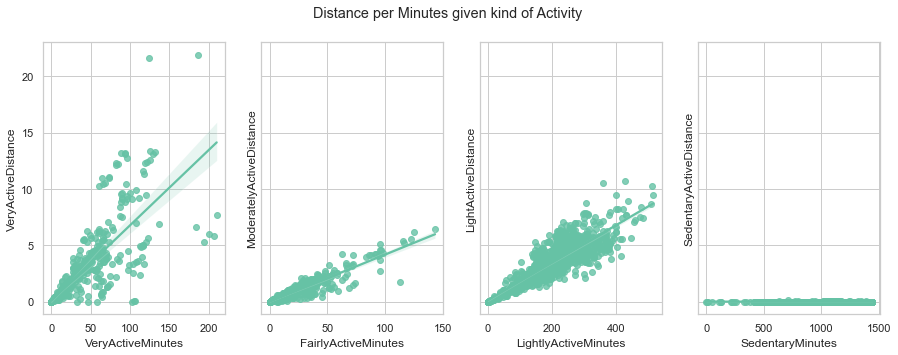

In [27]:
# Initial Exploratory Visualizations
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Distance per Minutes given kind of Activity')

sns.regplot(data = dailyActivity_df, x = 'VeryActiveMinutes', y = 'VeryActiveDistance', ax=axes[0])

sns.regplot(data = dailyActivity_df, x = 'FairlyActiveMinutes', y = 'ModeratelyActiveDistance', ax=axes[1])

sns.regplot(data = dailyActivity_df, x = 'LightlyActiveMinutes', y = 'LightActiveDistance', ax=axes[2])

sns.regplot(data = dailyActivity_df, x = 'SedentaryMinutes', y = 'SedentaryActiveDistance', ax=axes[3])

As expected, the VeryActive distances are traveled in shorter times (that is, they have larger speeds represented by steeper regression lines). A somewhat unexpected result here is that LightlyActiveMinutes lead to greater speeds than FairlyActiveMinutes. It would be interesting to know how this classification is done to actually understand the difference between "Light" activities and "Moderate" activities.

intercept: 1665.7426768758335
slope: [0.08351327]


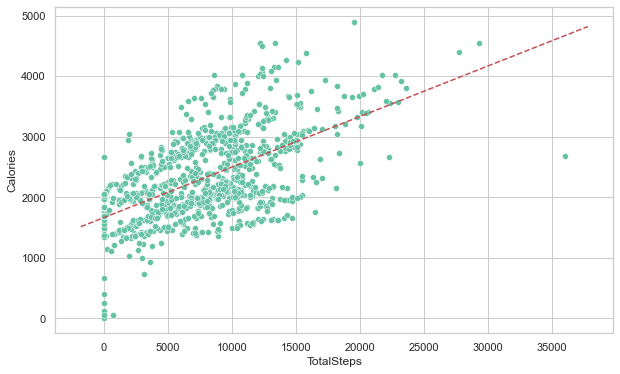

In [28]:
# fit a regression line to totalsteps and calories
X = full_dailyActivity_df['TotalSteps'].values.reshape((-1, 1))
y = full_dailyActivity_df['Calories'].values

model = LinearRegression()
model.fit(X, y)

print('intercept:', model.intercept_)
print('slope:', model.coef_)

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color= 'r', ls = '--')
    
sns.scatterplot(data = full_dailyActivity_df, x= 'TotalSteps', y ='Calories')
abline(model.coef_, model.intercept_);

Once more, as expected the amount of calories burned in a day grows as the user takes more steps. An intersting fact is that the intercept of the regression line represents the amount of burned calories in a day with no steps taken. This is the amount of calories users are burning in a very sedentary day. According to the Healthline site, this number corresponds to the basal metabolic rate. 

This value can be calculated if we know the user's sex, weight, height and age. 

For example, they report that a 35-year-old man who weighs 175 pounds and is 5 feet 11 inches would have a BMR of 1,816 calories and a 35-year-old woman who weighs 135 pounds and is 5 feet, 5 inches would have a BMR of 1,383 calories.

To compare these estimates with our data, we can get the intercept value using Linear Regression

The predicted BMR is ~1665.74 (between those predicted for the 35-year-old woman and man). 

We can further get information on the BMR of our users if we filter only the data points with zero steps taken and get the statistics on the Calories distribution. 

intercept: 1665.7426768758335
slope: [0.08351327]


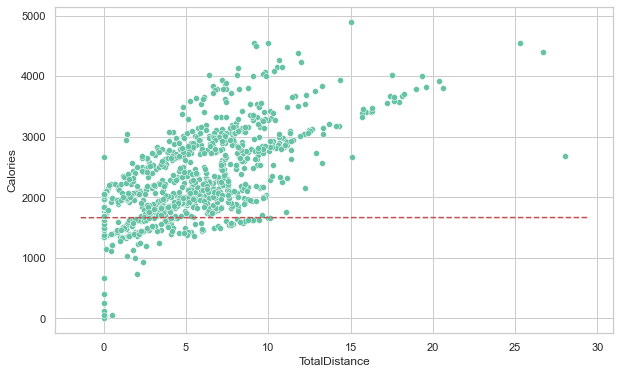

In [29]:
# fit a regression line to totalsteps and calories
X = full_dailyActivity_df['TotalSteps'].values.reshape((-1, 1))
y = full_dailyActivity_df['Calories'].values

model = LinearRegression()
model.fit(X, y)

print('intercept:', model.intercept_)
print('slope:', model.coef_)

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color= 'r', ls = '--')
    
sns.scatterplot(data = full_dailyActivity_df, x= 'TotalDistance', y ='Calories')
abline(model.coef_, model.intercept_);

In [30]:
full_dailyActivity_df[full_dailyActivity_df['TotalSteps']==0]['Calories'].describe()

count      77.000000
mean     1657.077922
std       557.082290
min         0.000000
25%      1496.000000
50%      1841.000000
75%      1980.000000
max      2664.000000
Name: Calories, dtype: float64

In [31]:
full_dailyActivity_df[full_dailyActivity_df['Calories']==0]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,day,month,year,dow
30,1503960366,2016-05-12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,12,05,2016,4
653,6290855005,2016-05-10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,10,05,2016,2
817,8253242879,2016-04-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,30,04,2016,6
879,8583815059,2016-05-12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,12,05,2016,4


There are many rows with all zero values except for the SedentaryMinutes column. In this column we see that users spent 1440 minutes of sedentary activity in a single day. 

That's the whole day: 
1440minutes divided by 60minutes/hour = 24h. 

So, it seems either the tracker may have been turned off the entire day or there may be some malfunction. We should get rid of these data points in further analysis.

In [32]:
# query full_info_activity
full_info_activity = """
SELECT *,
	STRFTIME('%d',ActivityDate) day,
	STRFTIME('%m',ActivityDate) month,
	STRFTIME('%Y',ActivityDate) year,
	STRFTIME('%w',ActivityDate) dow
FROM 
	dailyActivity_merged
WHERE
	Calories <> 0;
"""

full_dailyActivity_df = pd.read_sql(full_info_activity, con)

len(full_dailyActivity_df)

936

The dataset contains only 4 rows of non-usable data

intercept: 1689.1510000144017
slope: [0.08138959]


(1689.1510000144017, array([0.08138959]))

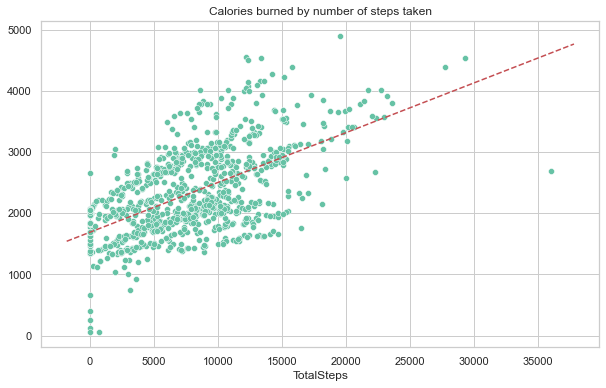

In [33]:
# fit a line for full daily activity and get intercept and slope 
def get_regression(full_dailyActivity_df, x ='TotalSteps', y = 'Calories'):
    X = full_dailyActivity_df[x].values.reshape((-1, 1))
    y = full_dailyActivity_df[y].values

    model = LinearRegression()
    model.fit(X, y)

    print('intercept:', model.intercept_)
    print('slope:', model.coef_)

    sns.scatterplot(data = full_dailyActivity_df, x= x, y =y)
    plt.title('Calories burned by number of steps taken')
    abline(model.coef_, model.intercept_);

    return (model.intercept_, model.coef_)

get_regression(full_dailyActivity_df)

Let's look at the data distribution for VeryActiveMinutes, FairlyActiveMinutes and LightlyActiveMinutes

### 1. Plot the distribution according to activity type - Partial day logged obtained in Q5 under activity 3.VeryActiveMinutes, FairlyActiveMinutes, LightlyActiveMinutes. Write your observation.

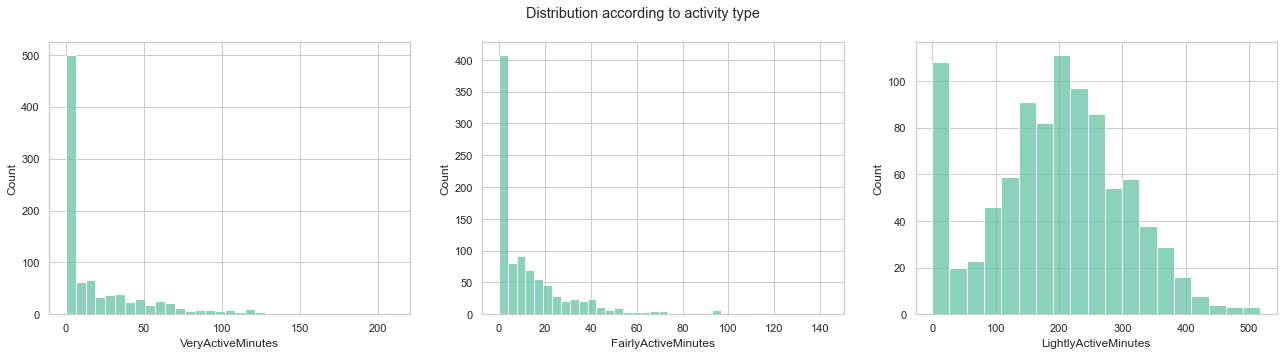

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Distribution according to activity type')

sns.histplot(data = full_dailyActivity_df, x = 'VeryActiveMinutes', ax = axes[0]);

sns.histplot(data = full_dailyActivity_df, x = 'FairlyActiveMinutes', ax = axes[1]);

sns.histplot(data = full_dailyActivity_df, x = 'LightlyActiveMinutes', ax = axes[2]);

There is an issue here: it is not clear if all users were using the tracker during the entire day in the analysed period. If a user logs the whole day, then the sum VeryActiveMinutes + FairlyActiveMinutes + LightlyActiveMinutes + SedentaryMinutes should be equal to 1440 minutes (the total number of minutes in a day).

In [35]:
full_day_activity = """
SELECT *,
	STRFTIME('%d',ActivityDate) day,
	STRFTIME('%m',ActivityDate) month,
	STRFTIME('%Y',ActivityDate) year,
	STRFTIME('%w',ActivityDate) dow,
	VeryActiveMinutes+FairlyActiveMinutes+LightlyActiveMinutes+SedentaryMinutes AS TotalMinutes
FROM 
	dailyActivity_merged
WHERE
	Calories <> 0 AND
	TotalMinutes = 1440;
"""

logged_day_df = pd.read_sql(full_day_activity, con)

print(f'There are {len(logged_day_df)} (out of {len(full_dailyActivity_df)}) rows where users logged the whole day.')

There are 474 (out of 936) rows where users logged the whole day.


In [36]:
not_full_day = """
SELECT *,
	STRFTIME('%d',ActivityDate) day,
	STRFTIME('%m',ActivityDate) month,
	STRFTIME('%Y',ActivityDate) year,
	STRFTIME('%w',ActivityDate) dow,
	VeryActiveMinutes+FairlyActiveMinutes+LightlyActiveMinutes+SedentaryMinutes AS TotalMinutes
FROM 
	dailyActivity_merged
WHERE
	Calories <> 0 AND
	TotalMinutes <> 1440;
"""

not_logged_day_df = pd.read_sql(not_full_day, con)

print(f'There are {len(not_logged_day_df)} rows where users logged parts of the day.')


There are 462 rows where users logged parts of the day.


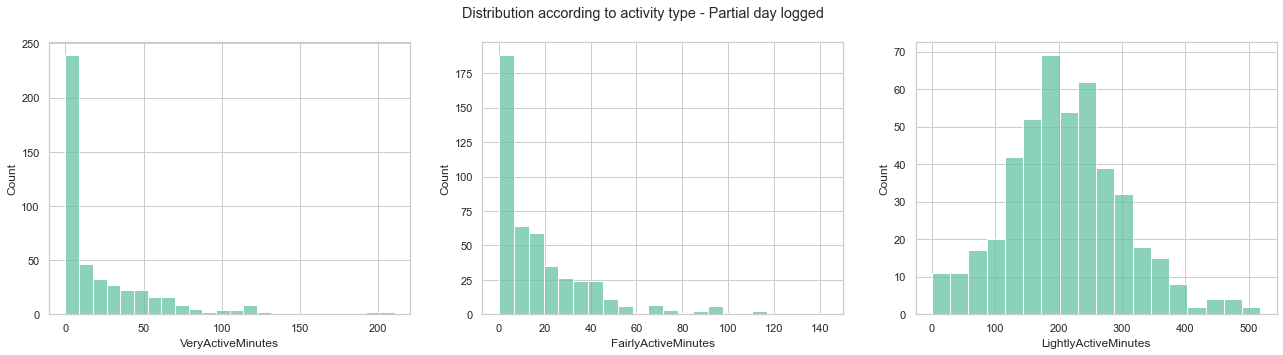

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Distribution according to activity type - Partial day logged')

sns.histplot(data = not_logged_day_df, x = 'VeryActiveMinutes', ax = axes[0]);

sns.histplot(data = not_logged_day_df, x = 'FairlyActiveMinutes', ax = axes[1]);

sns.histplot(data = not_logged_day_df, x = 'LightlyActiveMinutes', ax = axes[2]);

The LightlyActiveMinutes distribution is very symmetric with no peak at very few minutes of activity. Users who log the entire day may end up registering a lot of LightlyActiveMinutes while those who log only a part of the day might be registering only activities with higher demand.

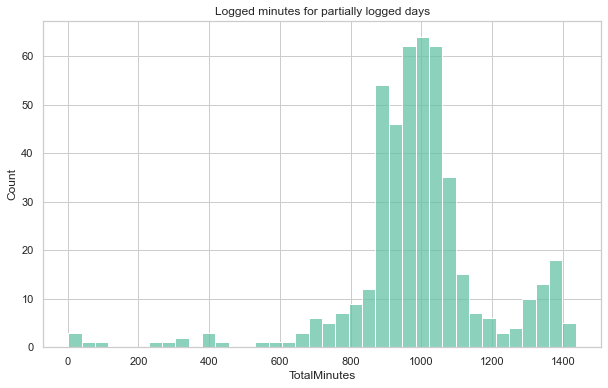

In [38]:
sns.histplot(data = not_logged_day_df, x = 'TotalMinutes')
plt.title('Logged minutes for partially logged days');

Let's take a look at the Sleeping Habits

Text(380, 30, '7h of sleep')

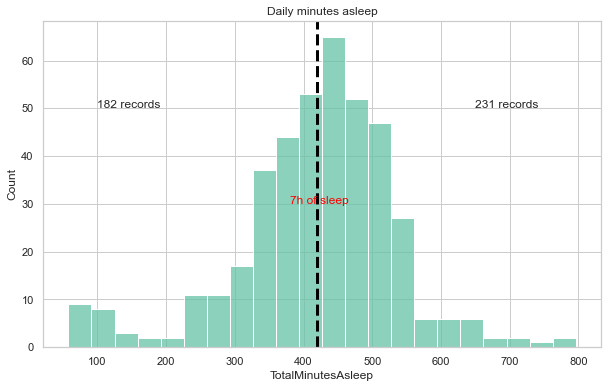

In [39]:
sns.histplot(data = sleep_df, x = 'TotalMinutesAsleep')
plt.title('Daily minutes asleep')

plt.axvline(420, 0, 65, color='black', ls = '--', lw = 3);

plt.annotate('182 records', (100,50))
plt.annotate('231 records', (650,50))
plt.annotate('7h of sleep', (380,30), color='red')

Does the day of the week make any difference?
Now that we had a galnce at our data and its distributions, does the day of the week make a considerable difference in user behavious?

### 3. Does day of week make any difference?. Visualize the dispersion of average steps, calories, and distance across days of the week using boxplot.

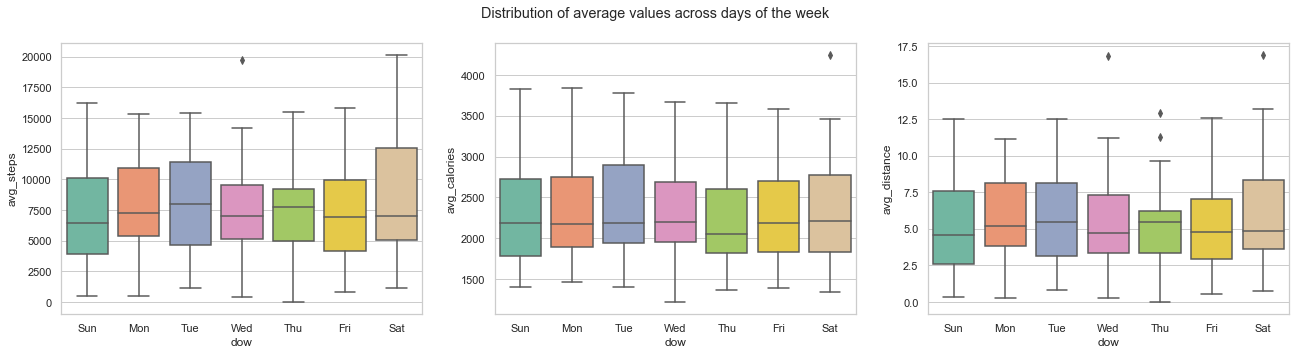

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Distribution of average values across days of the week')

sns.boxplot(x="dow", y="avg_steps", data=activity_dist, ax=axes[0]).set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri', 'Sat']);
sns.boxplot(x="dow", y="avg_calories", data=activity_dist, ax=axes[1]).set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri', 'Sat']);
sns.boxplot(x="dow", y="avg_distance", data=activity_dist, ax=axes[2]).set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri', 'Sat']);

### 4. Plot the distribution of calories and distance from the table "dailyActivity_merged".

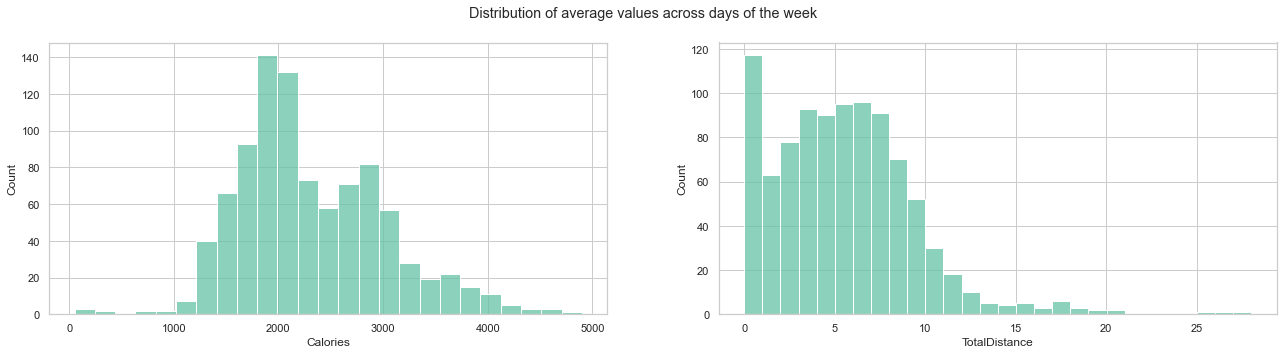

In [41]:
# distribution of calories and distance
fig, axes = plt.subplots(1, 2, figsize=(22, 5))
fig.suptitle('Distribution of average values across days of the week')

sns.histplot(data=full_dailyActivity_df, x="Calories", ax = axes[0]);

sns.histplot(data=full_dailyActivity_df, x="TotalDistance", ax = axes[1]);

How do sedentary minutes change in weekends?

### 5. How do sedentary minutes change in weekends?

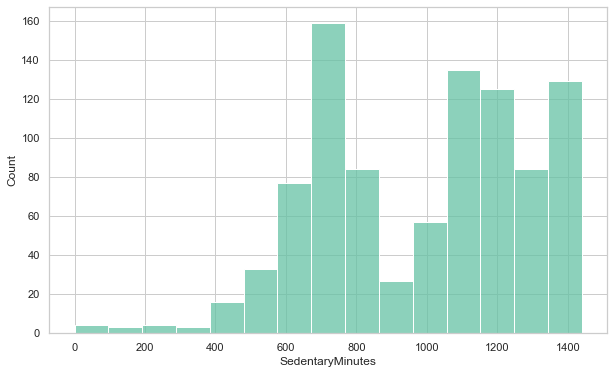

In [42]:
sns.histplot(data= weekend_check, x = 'SedentaryMinutes');

### 6. Create plots to visualize how this distribution depends on weekends and write your observation.

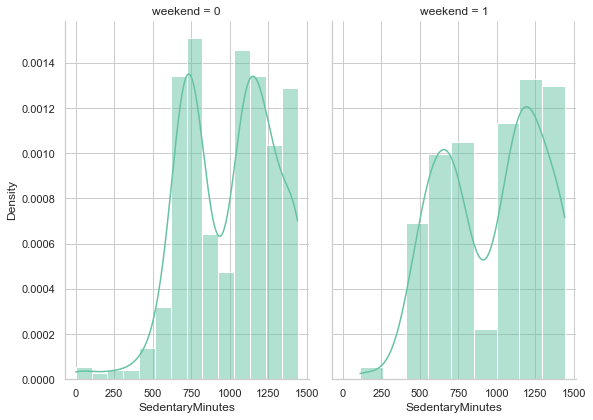

In [43]:
g = sns.FacetGrid(weekend_check, col="weekend", height=6, aspect=.7)
g.map(sns.histplot, "SedentaryMinutes", kde=True, stat='density');

We have now distinguished two groups of users based on the distribution of SedentaryMinutes

In [44]:
query = """
SELECT
	Id,
	AVG(SedentaryMinutes) AS AvgSedentaryMinutes
FROM
	dailyActivity_merged
GROUP BY
	Id
ORDER BY
	AvgSedentaryMinutes DESC;
"""
avg_sed_minutes = pd.read_sql(query, con)

avg_sed_minutes

,Id,AvgSedentaryMinutes
0,1927972279,1317.419355
1,6775888955,1299.423077
2,8253242879,1287.368421
3,8583815059,1267.225806
4,1624580081,1257.741935
5,4020332650,1237.258065
6,2320127002,1220.096774
7,4057192912,1217.250000
8,1844505072,1206.612903
9,6290855005,1193.034483


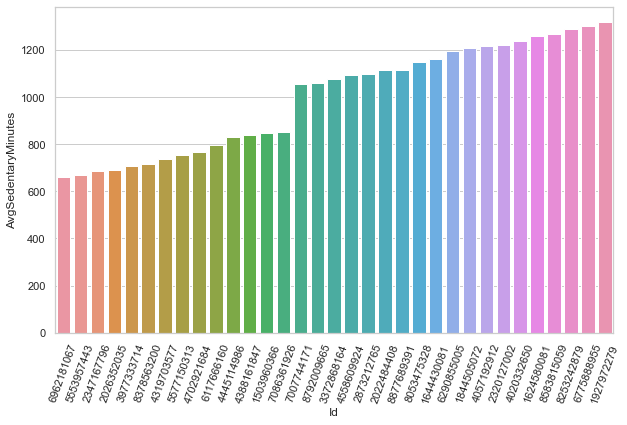

In [45]:
sns.barplot(data = avg_sed_minutes,
            x = 'Id', y = 'AvgSedentaryMinutes',
            order=avg_sed_minutes.sort_values('AvgSedentaryMinutes',ascending = True)['Id'])
plt.xticks(rotation=70);

It seems we may have found a trend here, there is a clear offset which seems to be around the borderline for the two groups. Let's verify that

In [46]:
# get avg sed minutes
cur.execute("SELECT	AVG(SedentaryMinutes) FROM dailyActivity_merged;")
sedMinAvg = cur.fetchall()[0][0]
print(sedMinAvg)

991.2106382978724


### 7. Create a columns to identify the user groups obtained in Q.6.

Rows in group 0 (Less Sedentary group):
416
Rows in group 1 (More Sedentary group):
524
Distinct users in group 0 (Less Sedentary group)
14
Distinct users in group 1 (More Sedentary group)
19


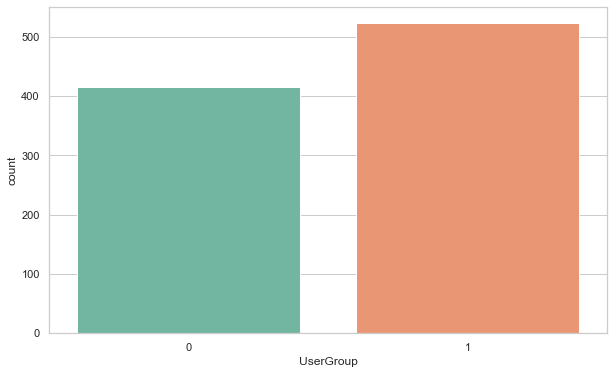

In [47]:
def is_above(user):
    '''Returns 1 if user has average SedentaryMinutes above the total average and 0 otherwise'''
    return int(avg_sed_minutes[avg_sed_minutes['Id']==user]['AvgSedentaryMinutes'].values[0] > sedMinAvg)

weekend_check['UserGroup'] = weekend_check['Id'].apply(is_above)

print(f'Rows in group 0 (Less Sedentary group):')
print(len(weekend_check[weekend_check['UserGroup']==0]))
print(f'Rows in group 1 (More Sedentary group):')
print(len(weekend_check[weekend_check['UserGroup']==1]))

print('Distinct users in group 0 (Less Sedentary group)')
print(weekend_check[weekend_check['UserGroup']==0]['Id'].nunique())

print('Distinct users in group 1 (More Sedentary group)')
print(weekend_check[weekend_check['UserGroup']==1]['Id'].nunique())

sns.countplot(data=weekend_check, x = 'UserGroup');

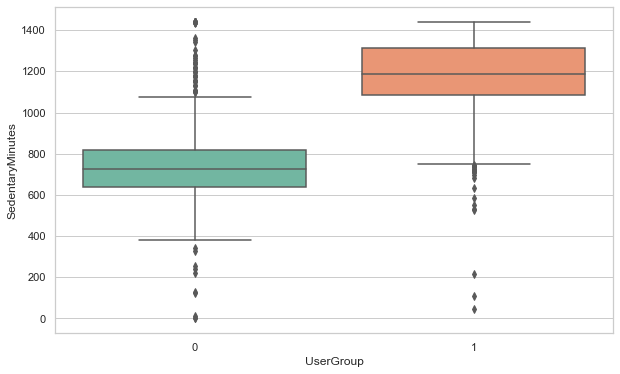

In [48]:
sns.boxplot(x="UserGroup", y="SedentaryMinutes", data=weekend_check);

### 8. What do you observe from sleeping habits of each user group? Report your observation with a boxplot and a countplot. Also, print the values in each group.

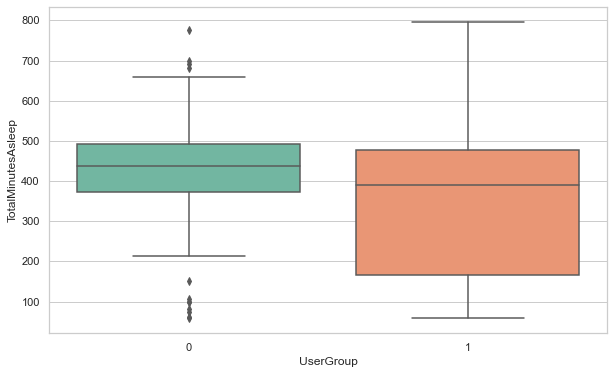

In [49]:
sleep_df['UserGroup'] = sleep_df['Id'].apply(is_above)

sns.boxplot(x="UserGroup", y="TotalMinutesAsleep", data=sleep_df);


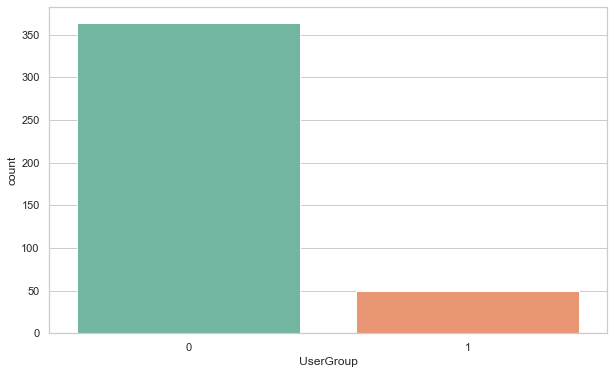

In [50]:
sns.countplot(data = sleep_df, x = 'UserGroup');

In [51]:
sleep_df['UserGroup'].value_counts()

0    364
1     49
Name: UserGroup, dtype: int64

### 9. Plot distinct users in each group.

In [52]:
print('Distinct users in group 0 (Less Sedentary group)')
print(sleep_df[sleep_df['UserGroup']==0]['Id'].nunique())

print('Distinct users in group 1 (More Sedentary group)')
print(sleep_df[sleep_df['UserGroup']==1]['Id'].nunique())

Distinct users in group 0 (Less Sedentary group)
14
Distinct users in group 1 (More Sedentary group)
10


### 10.Inspect the datasets to formulate a join query and prepare a new dataframe “activity_sleep_df” to report a regression plot between Total Minutes Asleep and Sedentary Minutes. Write your observation on sedentary users from the reported trend line.

<AxesSubplot:xlabel='TotalMinutesAsleep', ylabel='SedentaryMinutes'>

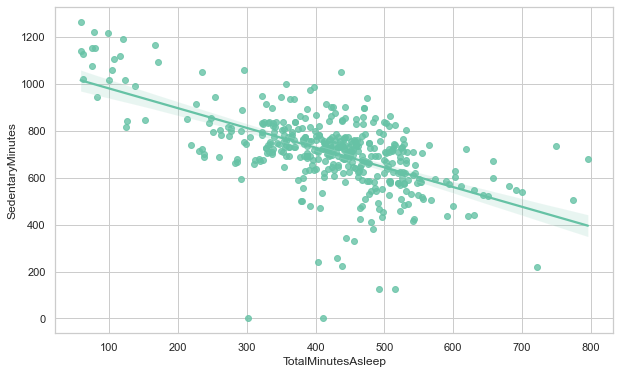

In [53]:
# Join activity and sleep data
join_query = """
SELECT 
	A.Id,
	A.ActivityDate,
	A.SedentaryMinutes,
	S.TotalMinutesAsleep
FROM 
	dailyActivity_merged A
INNER JOIN sleepDay_merged S
ON 
	A.Id = S.Id AND
    A.ActivityDate = S.SleepDay;
"""
activity_sleep_df = pd.read_sql(join_query, con)

sns.regplot(data = activity_sleep_df,
                x = 'TotalMinutesAsleep',
                y = 'SedentaryMinutes')